# Kaggle：预测房价
## 导入数据集

In [31]:
import pandas as pd
import torch
from torch.utils import data
import d2l.torch as d2l

In [2]:
train_data = pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('../data/house-prices-advanced-regression-techniques/test.csv')

In [3]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [4]:
train_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


## 数据预处理
### 删除无效特征

让我们看看前四个和最后两个特征，以及标签：

In [5]:
train_data.iloc[:4, [0, 1, 2, 3, 4, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,WD,Normal,208500
1,2,20,RL,80.0,9600,WD,Normal,181500
2,3,60,RL,68.0,11250,WD,Normal,223500
3,4,70,RL,60.0,9550,WD,Abnorml,140000


可以看到，每个样本的第一维特征是Id，它不携带任何用于预测的信息。因此，在将数据提供给模型之前，我们将其从数据中删除。

In [6]:
all_features = pd.concat([train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]], axis=0)

In [7]:
all_features.shape

(2919, 79)

### 数值型特征标准化

In [8]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / x.std())

### 数值型特征缺失值填充0

In [9]:
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [10]:
all_features[numeric_features] 

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0.348780,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,0.157619
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,-0.059772,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.446848,-0.602858
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0.627338,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,0.157619
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0.785188,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,-1.363335
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,1.685860,0.776834,0.540332,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,2.131647,0.157619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,-2.195385,-0.740634,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.078492,-1.363335
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,-0.867591,-0.740634,-0.347564,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.815205,-1.363335
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0.478774,3.005615,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,-1.363335
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,-2.195385,-0.108355,-0.229178,-0.359539,-0.103313,-0.285886,-0.063139,1.144116,0.289865,-1.363335


### 离散型特征独热编码

In [11]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

现在特征的数量从79个增加到331个。最后，通过values属性，我们可以从pandas格式中提取numpy格式，并将其转换为张量用于训练。

In [12]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data['SalePrice'].values.reshape(-1, 1), dtype=torch.float32)

In [13]:
train_dataset = data.TensorDataset(*(train_features, train_labels))
train_iter = data.DataLoader(train_dataset, shuffle=True, batch_size=64)

## 训练
首先，我们训练一个带有损失平方的线性模型。 显然线性模型很难让我们在竞赛中获胜，但线性模型提供了一种健全性检查， 以查看数据中是否存在有意义的信息。 如果我们在这里不能做得比随机猜测更好，那么我们很可能存在数据处理错误。 如果一切顺利，线性模型将作为基线（baseline）模型， 让我们直观地知道最好的模型有超出简单的模型多少。

In [14]:
import torch.nn as nn
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。
因此，[**我们更关心相对误差$\frac{y - \hat{y}}{y}$，**]
而不是绝对误差$y - \hat{y}$。

(**解决这个问题的一种方法是用价格预测的对数来衡量差异**)。
事实上，这也是比赛中官方用来评价提交质量的误差指标。
即将$\delta$ for $|\log y - \log \hat{y}| \leq \delta$
转换为$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$。
这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

In [23]:
def log_rmse(net, fetures, labels):
    # 为了在取对数时进一步稳定数值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(fetures), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

与前面的部分不同，[我们的训练函数将借助Adam优化器] （我们将在后面章节更详细地描述它）。 Adam优化器的主要吸引力在于它对初始学习率不那么敏感。

In [24]:
def train(net, train_iter, test_features, test_labels, 
         num_epochs, learning_rate, weight_decay, batch_size):
    train_ls = []
    test_ls = []
    optimizer = torch.optim.Adam(net.parameters(), 
                                 lr = learning_rate, 
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        # 一个epoch训练结束，用当前网络计算训练误差
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证
K折交叉验证有助于模型选择和超参数调整。 我们首先需要定义一个函数，在 𝐾 折交叉验证过程中返回第 𝑖 折的数据。 具体地说，它选择第 𝑖 个切片作为验证数据，其余部分作为训练数据。注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，会有其他解决办法。

In [25]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

当我们在 𝐾 折交叉验证中训练 𝐾 次后，[返回训练和验证误差的平均值]。

In [29]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, 
           weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        X_train, y_train, X_valid, y_valid = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_iter = data.DataLoader(data.TensorDataset(*(X_train, y_train)))
        train_ls, valid_ls = train(net, train_iter, X_valid, y_valid, num_epochs, learning_rate, 
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 模型选择
在本例中，我们选择了一组未调优的超参数，并将其留给读者来改进模型。 找到一组调优的超参数可能需要时间，这取决于一个人优化了多少变量。 有了足够大的数据集和合理设置的超参数， 𝐾 折交叉验证往往对多次测试具有相当的稳定性。 然而，如果我们尝试了不合理的超参数，我们可能会发现验证效果不再代表真正的误差。

折1，训练log rmse0.133224, 验证log rmse0.164952
折2，训练log rmse0.139887, 验证log rmse0.170130
折3，训练log rmse0.159009, 验证log rmse0.157356
折4，训练log rmse0.150436, 验证log rmse0.185439
折5，训练log rmse0.152215, 验证log rmse0.137052
5-折验证: 平均训练log rmse: 0.146954, 平均验证log rmse: 0.162986


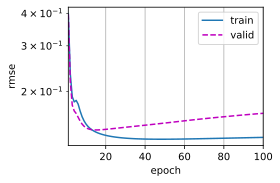

In [32]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

## 预测
在确定使用什么样的超参数之后，我们就可以在所有数据上进行训练，然后将模型应用与测试集，将预测结果保存在csv文件中。

In [43]:
def train_and_pred(train_features, train_label, test_feature, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_iter = data.DataLoader(data.TensorDataset(*(train_features, train_label)), 
                                 shuffle=True, batch_size=batch_size)
    train_ls, _ = train(net, train_iter, None, None, num_epochs, 
                        lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

In [45]:
train_and_pred(train_features, train_labels, test_features, test_data,
               num_epochs, lr, weight_decay, batch_size)

NameError: name 'np' is not defined